# Introduction

We have a hypothetical source of ecommerce data that we are going to use to perform funnel analysis.

Most of the time, websites have a clear path to conversion - land on home page -> search -> select a product -> buy product.

The problem is that users drop off at every stage of the path, and when visualized that amount per stage ends up looking like a funnel.

So funnel analysis allows us to understand where and when our users abandon our website.  It gives insight on user behavior, how to improve our UX, and also helps to discover bugs.

The site that we're studying has the following user flow:  When you come to the site for the first time, you can only land on the home page as a first page. From the home page, the user can perform a search and land on the search page. From the search page, if the user clicks on a product, they will get to the payment page, where they are asked to provide payment information in order to buy that product.  If they do decide to buy, they ends up on the confirmation page.

We're going to try to figure out how to improve the volume of sales overall as well as in particular for new users.  Therefore we're going to perform a funnel analysis to see where it breaks down as well as offer some suggestions on how to improve the conversion rate in general.  Hopefully by the end of the analysis we'll get a better idea on our conversion rates for mobile and desktop, as well as give the product team insights on where we need to improve in order to bump up our conversion rate.

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
import seaborn as sns
import scipy.stats as stats
import itertools
from sklearn.utils import shuffle
# Importing Machine learning models library used for classification
# from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
##
from scipy.stats import skew, skewtest
import lifelines as sa
from lifelines.utils import concordance_index, k_fold_cross_validation

# Run KM Survival Analysis
from lifelines.estimation import KaplanMeierFitter
#Run Cox Proportional Hazards
from lifelines import CoxPHFitter

from sklearn.utils import shuffle
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression, Perceptron, LogisticRegression
import datetime
# Importing Machine learning models library used for classification
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split, cross_val_score,KFold
from sklearn.naive_bayes import GaussianNB as GB
from sklearn.svm import SVC
from sklearn import metrics, preprocessing
from sklearn.preprocessing import MinMaxScaler
# import the class
from sklearn.feature_selection import f_regression,f_classif
from sklearn import metrics

import matplotlib.patheffects as path_effects
from sklearn.metrics import confusion_matrix, accuracy_score,roc_curve, auc,mean_squared_error, f1_score
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn import tree

%matplotlib inline
plt.style.use('fivethirtyeight')

# import tpot
%config InlineBackend.figure_format = 'png' 
%matplotlib inline
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

In [239]:

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, \
                          labels = ['Did Not Convert', 'Converted']):
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, fontsize = 12)
    plt.yticks(tick_marks, labels, rotation = 90, fontsize = 12)
        
    plt.title(title, fontsize = 24)
    plt.ylabel('True', fontsize = 18)
    plt.xlabel('Predicted', fontsize = 18)
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in range(0,width):
        for y in range(0,height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, \
                                foreground='black'), path_effects.Normal()])
    return


def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5))
    return(rmse)


def model_building(dframe,X,y, pred_model):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    print("Building model %s" %pred_model)
    if pred_model == 'Random Forest':
        modl = RandomForestClassifier(class_weight={0:.995,1:.005})
    elif pred_model == 'SVM Linear':
        modl = SVC(kernel='linear')
    elif pred_model == 'SVM RBF':
        modl = SVC(kernel='rbf')
    elif pred_model == 'Logistic Regression':
        modl = LogisticRegression(class_weight={0:.995,1:.005})
    elif pred_model == 'kNN':
        ref_score = -99
        nbr_neighbors = -9
        for k in range(2,10):
            print("In loop for %s neighbors" %k)
            modl = KNeighborsClassifier(n_neighbors=k)
            modl.fit(X_train, y_train)
            modl.predict(X_test)
            if modl.score(X_test, y_test) > ref_score:
                ref_score = modl.score(X_test, y_test)
                nbr_neighbors = k

        modl = KNeighborsClassifier(n_neighbors=nbr_neighbors)
        print("%s is the optimal number of neighbors" %nbr_neighbors)

    modl.fit(X_train, y_train)
    y_pred = modl.predict(X_test) 

    if pred_model == 'Random Forest':
        labels = list(dframe.columns.values)
        labels.remove('converted')
#         labels.remove('employment_length')
        feat_importance = pd.DataFrame(modl.feature_importances_, columns=['values'])
        feat_importance['index'] = labels
        feat_importance = feat_importance.set_index('index')
        feat_importance = feat_importance.sort_values(['values'], ascending=False)
        print("Features importance: %s" %feat_importance)

    print("Accuracy for %s = %s" %(pred_model, round(100.*modl.score(X_test, y_test), 2)))
    print confusion_matrix(y_test, y_pred)
    
    ####
    logit = y_pred
    y_pred_prob = modl.predict_proba(X_test)[:, 1]
    # histogram of predicted probabilities of people leaving the company 
    plt.hist(y_pred_prob, bins=5)
    plt.xlim(0, 1)
    plt.title('Histogram of Predicted Probabilities')
    plt.xlabel('Predicted Probability of Conversion')
    plt.ylabel('Frequency')
    cm = confusion_matrix(y_test, logit)


    plot_confusion_matrix(cm, title='Model: Confusion Matrix', \
                          labels=['Did Not Convert', 'Converted'], cmap=plt.cm.Greens) 
    # Roc_curve for Logistic Regression Model
    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(y_test, logit)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    # Plot of a ROC curve for class 1 (employee left)
    plt.figure(figsize=[5,5])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0, 1])
    plt.ylim([0, 1.5])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('Model Receiver operating characteristic for Conversion', fontsize=18)
    plt.legend(loc="upper left")
    plt.show()
    
def plot_variables(variable_list, file_location='../figures/categorical_vars.png'):
    plt.rcParams['figure.figsize'] = (16, 14)
    for i,j in itertools.izip_longest(variable_list,range(len(variable_list))): # itertools.zip_longest for to execute the longest loop
        plt.subplot(np.ceil(len(variable_list)/2),2,j+1)
        plt.subplots_adjust(hspace=.5)
        sns.countplot(x=i,data = df)
        plt.xticks(rotation=45)
        plt.title(str("No. of Users by "+i.title()))
        # Get current axis on current figure
        ax = plt.gca()

        # Iterate through the list of axes' patches
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                    fontsize=12, color='black', ha='center', va='bottom')
    plt.savefig(file_location)

# Organize
Organize the data into a usable subset

#### Tables
1. "user_table" - info about the user 
2. "home_page_table" - Users who landed on the home page
3. "search_page_table" - Users who landed on the search_page
4. "payment_page_table" - Users who landed on the payment_page
5. "payment_confirmation_table" - Users who landed on the payment_confirmation_table. That is, these are the users who bought the product

In [240]:
user_table = pd.read_csv('../data/user_table.csv',index_col="user_id")
home_page_table = pd.read_csv('../data/home_page_table.csv',index_col="user_id")
search_page_table = pd.read_csv('../data/search_page_table.csv',index_col="user_id")
payment_page_table = pd.read_csv('../data/payment_page_table.csv',index_col="user_id")
payment_confirmation_table = pd.read_csv('../data/payment_confirmation_table.csv',index_col="user_id")

Let's add the information in the page tables back into the user table

In [241]:
home_page_table.loc[search_page_table.index,"final_page"] = search_page_table.page
home_page_table.loc[payment_page_table.index,"final_page"] = payment_page_table.page
home_page_table.loc[payment_confirmation_table.index,"final_page"] = payment_confirmation_table.page

In [242]:
pages = ["home_page","search_page","payment_page","payment_confirmation_page"]
home_page_table["final_page"] = home_page_table.final_page.astype("category",categories = pages,ordered=True)

In [243]:
home_page_table.final_page = home_page_table.final_page.fillna('home_page')

In [244]:
home_page_table = home_page_table.join(user_table)

In [245]:
home_page_table['date'] =pd.to_datetime(home_page_table['date'])

In [246]:
## Change var names in this - also it looks wrong - 
# the numbers are correct but the columns represented are in the wrong order.
# The max should be home_page, then search, then payment, then payment_confirmation
def conversion_rates(df):
    stage_counts = df.final_page.value_counts()
    convert_from = stage_counts.copy()

    total = df.shape[0]
    for page in stage_counts.index:
        n_left = stage_counts.loc[page]# how many users just stop at current page
        n_convert = total - n_left
        convert_from[page] = n_convert
        total = n_convert

    cr = pd.concat([stage_counts,convert_from],axis=1,keys=["n_drop","n_convert"])
    cr["convert_rates"] = cr.n_convert.astype(np.float)/(cr.n_drop + cr.n_convert)
    cr['drop_rates'] = 1 - cr.convert_rates

    return cr


In [247]:
stage_counts = home_page_table.final_page.value_counts()
convert_from = stage_counts.copy()

total = home_page_table.shape[0]
for page in stage_counts.index:
    n_left = stage_counts.loc[page]# how many users just stop at current page
    n_convert = total - n_left
    convert_from[page] = n_convert
    total = n_convert
    print page
    print n_left, n_convert, total

home_page
45200 45200 45200
search_page
39170 6030 6030
payment_page
5578 452 452
payment_confirmation_page
452 0 0


In [248]:
conversion_rates(home_page_table)

,n_drop,n_convert,convert_rates,drop_rates
home_page,45200,45200,0.500000,0.500000
search_page,39170,6030,0.133407,0.866593
payment_page,5578,452,0.074959,0.925041
payment_confirmation_page,452,0,0.000000,1.000000


As we can see, half of the users stop at the home_page while the other half continues to the search page.  Of those that make the search page, 13% continue to the payment page. Of the 13% that make it the pagement page, 7% make it to the pagement confirmation page.

In [249]:
home_page_table.groupby('device').apply(conversion_rates)

n_drop  n_convert  convert_rates  \
device                                                                
Desktop home_page                   30100      30100       0.500000   
        search_page                 27090       3010       0.100000   
        payment_page                 2860        150       0.049834   
        payment_confirmation_page     150          0       0.000000   
Mobile  home_page                   15100      15100       0.500000   
        search_page                 12080       3020       0.200000   
        payment_page                 2718        302       0.100000   
        payment_confirmation_page     302          0       0.000000   

                                   drop_rates  
device                                         
Desktop home_page                    0.500000  
        search_page                  0.900000  
        payment_page                 0.950166  
        payment_confirmation_page    1.000000  
Mobile  home_page                    0.500000  
        search_page                  0.800000  
        payment_page                 0.900000  
        payment_confirmation_page    1.000000

** Desktop Users **

So here we see that half of the desktop users stop at the home_page while the other half continues to the search page.  Of those that make the search page, 10% continue to the payment page. Of the 10% that make it the pagement page, 5% make it to the pagement confirmation page.

**Mobile Users**

Half of the mobile users stop at the home_page while the other half continues to the search page.  Of those that make the search page, 20% continue to the payment page. This a 200% increase compared to our desktop users or 2x better.  Of the 20% that make it the pagement page, 10% make it to the pagement confirmation page.

Overall from the looks of it, Mobile users are converting at a higher % although they have less users.

I would suggests we make changes so that we can leverage this mobile userbase. Or if the UI/UX is the problem for desktop, make it more friendly.

### Question 2


In [251]:
home_page_table['converted'] = (home_page_table.final_page == 'payment_confirmation_page').astype(int)
home_page_table['weekday_name'] = home_page_table.date.dt.weekday_name
home_page_table['weekday'] = home_page_table.date.dt.weekday
home_page_table['month'] = home_page_table.date.dt.month

In [252]:
home_page_table.loc[home_page_table.final_page.isnull(), 'final_page'] = "home_page"

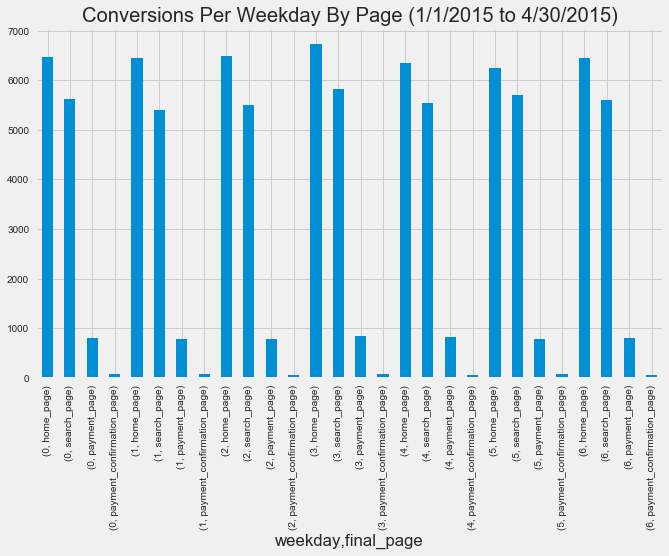

In [253]:
home_page_table.groupby('weekday')['final_page'].value_counts().plot(kind = 'bar', title = 'Conversions Per Weekday By Page (1/1/2015 to 4/30/2015)')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/Conversions Per Weekday By Page.png')


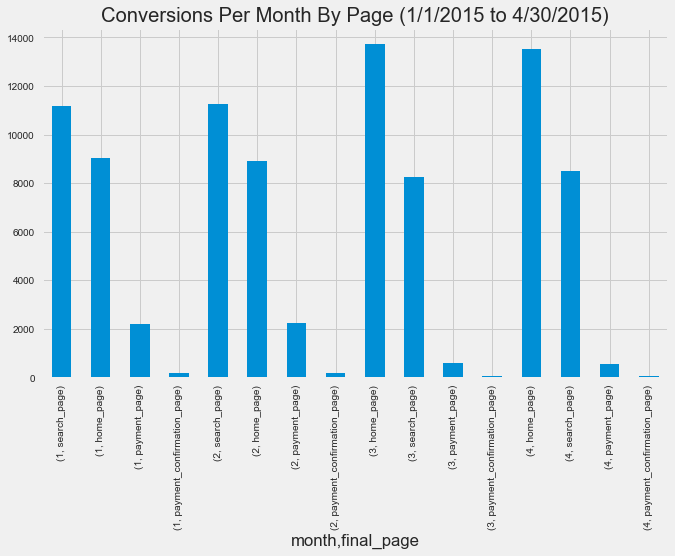

In [254]:
home_page_table.groupby('month')['final_page'].value_counts().plot(kind = 'bar', title = 'Conversions Per Month By Page (1/1/2015 to 4/30/2015)')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/Conversions Per Month By Page.png')


In [255]:
home_page_table.head(10)

,page,final_page,date,device,sex,converted,weekday_name,weekday,month
user_id,,,,,,,,,
313593,home_page,home_page,2015-02-26,Desktop,Female,0,Thursday,3,2
468315,home_page,home_page,2015-02-21,Desktop,Male,0,Saturday,5,2
264005,home_page,home_page,2015-03-25,Desktop,Female,0,Wednesday,2,3
290784,home_page,home_page,2015-03-14,Desktop,Male,0,Saturday,5,3
639104,home_page,search_page,2015-01-03,Desktop,Female,0,Saturday,5,1
262889,home_page,home_page,2015-01-10,Mobile,Male,0,Saturday,5,1
708793,home_page,home_page,2015-04-24,Mobile,Female,0,Friday,4,4
943143,home_page,search_page,2015-04-10,Desktop,Male,0,Friday,4,4
417894,home_page,home_page,2015-04-02,Mobile,Female,0,Thursday,3,4


Split into Day / Weekday / Mnoth Sections

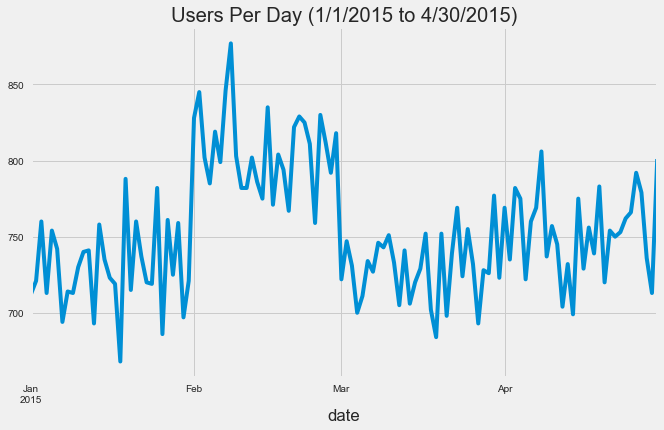

In [256]:
ax = home_page_table.groupby('date')['page'].count().plot(kind = 'line', title = 'Users Per Day (1/1/2015 to 4/30/2015)')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/Users Per Day.png')

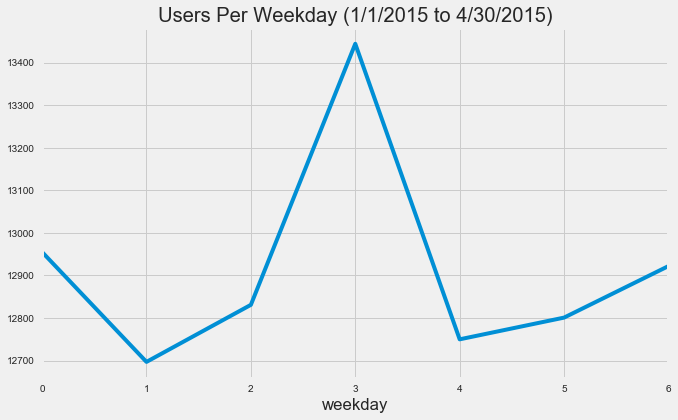

In [257]:
ax = home_page_table.groupby('weekday')['page'].count().plot(kind = 'line', title = 'Users Per Weekday (1/1/2015 to 4/30/2015)')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/Users Per Weekday.png')

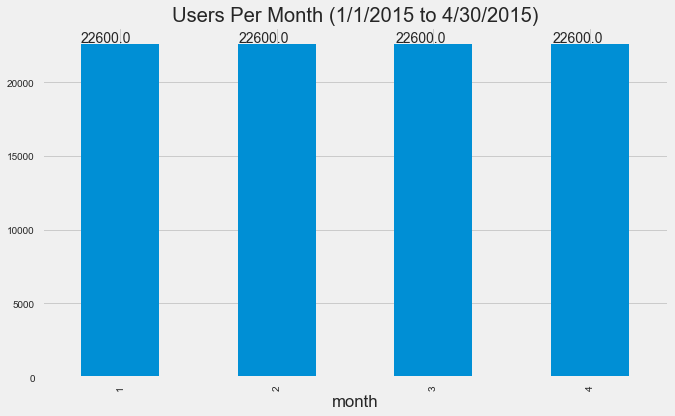

In [258]:
ax = home_page_table.groupby('month')['page'].count().plot(kind = 'bar', title = 'Users Per Month (1/1/2015 to 4/30/2015)')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/Users Per Month.png')

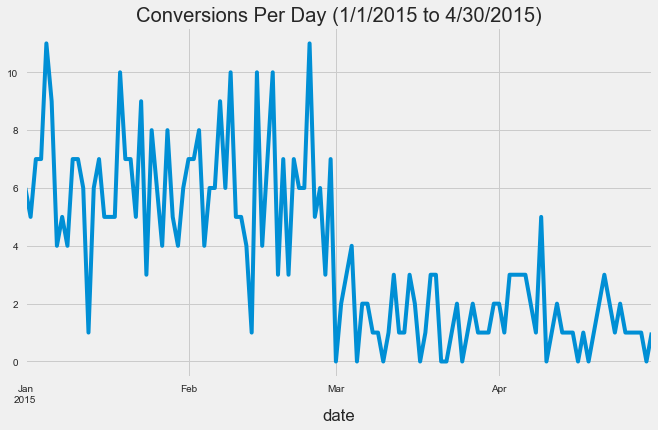

In [259]:
ax = home_page_table.groupby('date')['converted'].sum().plot(kind = 'line', title = 'Conversions Per Day (1/1/2015 to 4/30/2015)')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/Conversions Per Day.png')

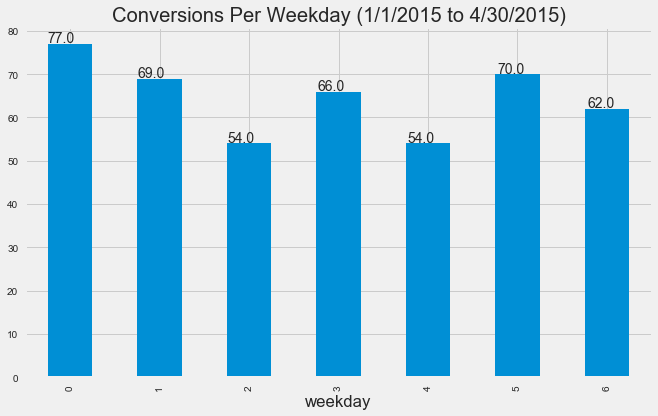

In [260]:
ax = home_page_table.groupby('weekday')['converted'].sum().plot(kind = 'bar', title = 'Conversions Per Weekday (1/1/2015 to 4/30/2015)')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/Conversions Per Weekday.png')

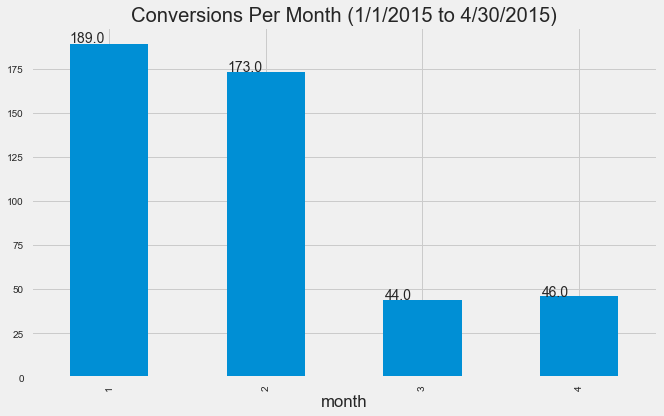

In [261]:
ax = home_page_table.groupby('month')['converted'].sum().plot(kind = 'bar', title = 'Conversions Per Month (1/1/2015 to 4/30/2015)')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/Conversions Per Month.png')

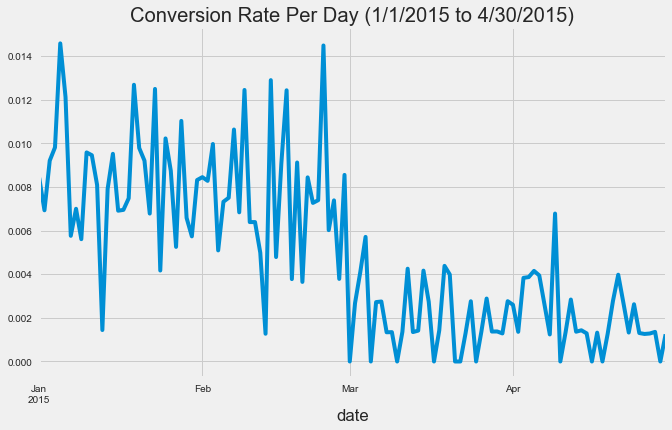

In [262]:
ax = home_page_table.groupby('date')['converted'].mean().plot(kind = 'line', title = 'Conversion Rate Per Day (1/1/2015 to 4/30/2015)')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/Conversion Rate Per Day.png')

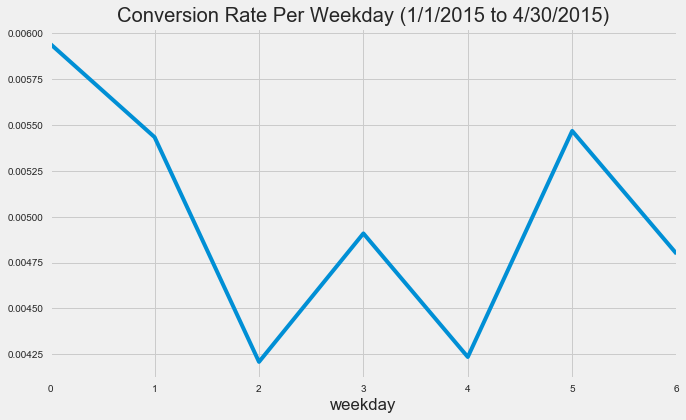

In [263]:
ax = home_page_table.groupby('weekday')['converted'].mean().plot(kind = 'line', title = 'Conversion Rate Per Weekday (1/1/2015 to 4/30/2015)')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/Conversion Rate Per Weekday.png')

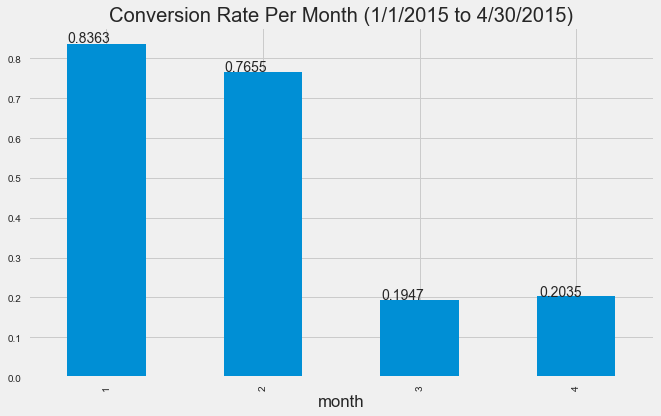

In [264]:
ax = (home_page_table.groupby('month')['converted'].mean()*100).round(4).plot(kind = 'bar', title = 'Conversion Rate Per Month (1/1/2015 to 4/30/2015)')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/Conversion Rate Per Month.png')

As we can see, it the month of January has the highest conversion rate, but when comparing user counts we see that January has the lowest user count per day.

In [265]:
home_page_table = home_page_table.rename(columns = {'final_page':'last_page'})
# df.rename(columns = {'Grad Year':'graduationyear','Height (inches)':'height'})

In [266]:
final_page = pd.get_dummies(home_page_table['last_page']) 

In [267]:
home_page_table = pd.merge(home_page_table,final_page,right_index=True, left_index=True)

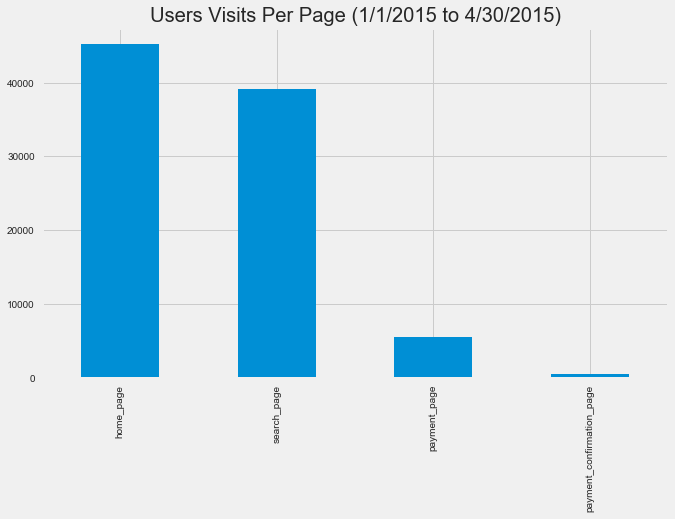

In [268]:
home_page_table[['home_page','search_page','payment_page','payment_confirmation_page']].sum().plot(kind = 'bar', title = 'Users Visits Per Page (1/1/2015 to 4/30/2015)')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.savefig('../figures/Users Visits Per Page.png')

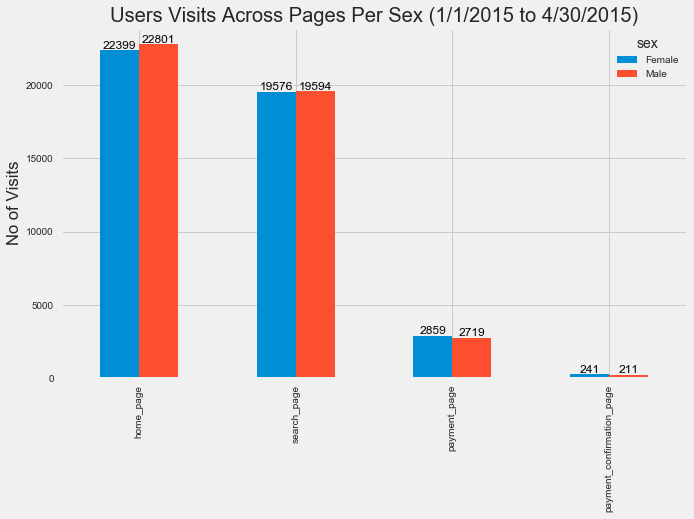

In [269]:
ax = home_page_table.groupby('sex')['home_page','search_page','payment_page','payment_confirmation_page'].sum().T.plot(kind = 'bar', title = 'Users Visits Across Pages Per Sex (1/1/2015 to 4/30/2015)')
ax.set_ylabel('No of Visits')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.savefig('../figures/Users Visits Per Page Per Sex.png')

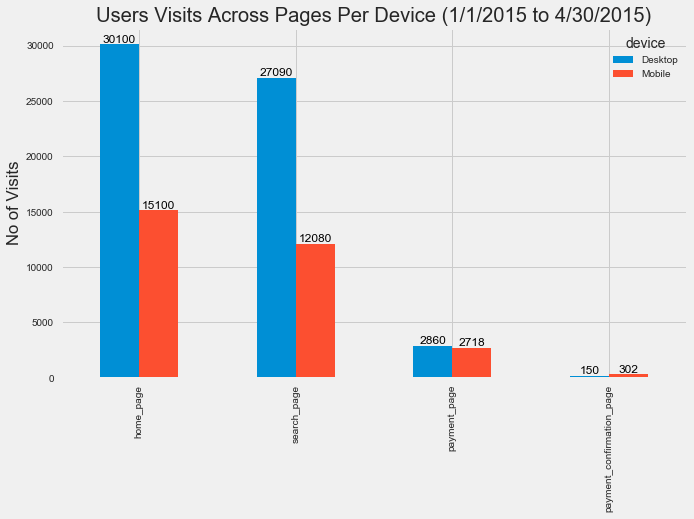

In [270]:
ax = home_page_table.groupby('device')['home_page','search_page','payment_page','payment_confirmation_page'].sum().T.plot(kind = 'bar', title = 'Users Visits Across Pages Per Device (1/1/2015 to 4/30/2015)')
ax.set_ylabel('No of Visits')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.savefig('../figures/Users Visits Per Page Per Device.png')

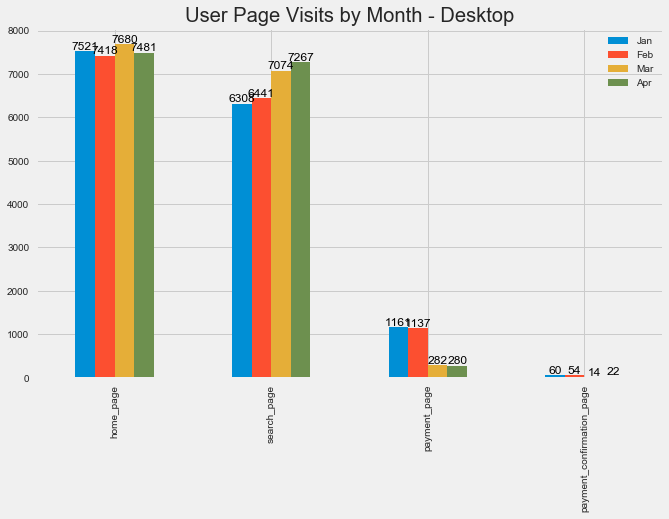

In [271]:
ax = home_page_table[home_page_table['device'] == 'Desktop'].groupby('month')['home_page','search_page','payment_page','payment_confirmation_page'].sum().T.plot(kind = 'bar', title = 'Users Visits Across Pagees Per Device (1/1/2015 to 4/30/2015)')
ax.set_title('User Page Visits by Month - Desktop')
ax.legend(['Jan','Feb','Mar','Apr'])

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.savefig('../figures/Desktop Users Visits Per Month .png')


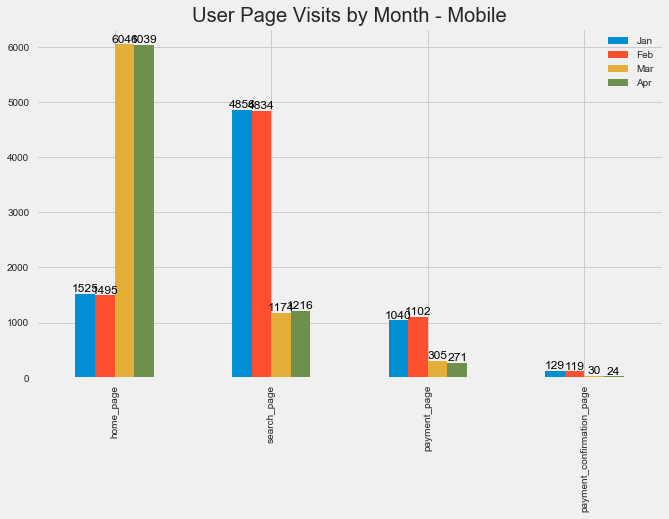

In [272]:
ax = home_page_table[home_page_table['device'] == 'Mobile'].groupby('month')['home_page','search_page','payment_page','payment_confirmation_page'].sum().T.plot(kind = 'bar', title = 'Users Visits Across Pagees Per Device (1/1/2015 to 4/30/2015)')
ax.set_title('User Page Visits by Month - Mobile')
ax.legend(['Jan','Feb','Mar','Apr'])

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.savefig('../figures/Mobile User Visits Per Month.png')


Do mobile users skip the homepage? 

This reminds me of a blog post written by a data scientist at stack overflow which speaks on the fact that people enter their site on specific pages because one often searches for an answer to a question on Google and the top result is a Stack Overflow link which takes them to a specific page on the site.  

Now that I think abot it, I don't even know what the home page of Stack Overflow looks like!


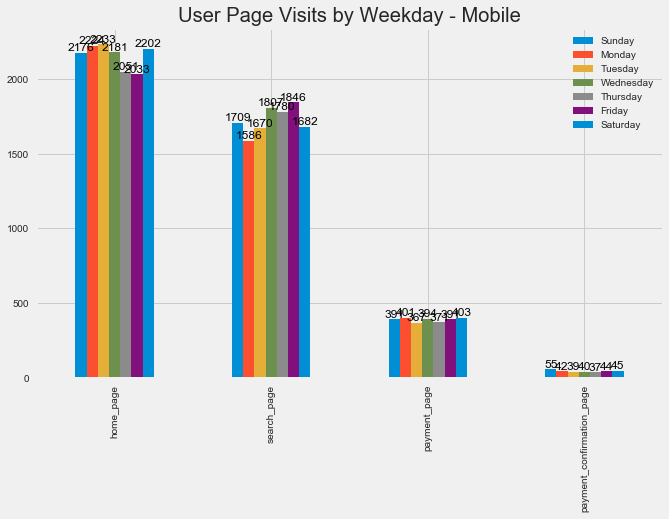

In [273]:
ax = home_page_table[home_page_table['device'] == 'Mobile'].groupby('weekday')['home_page','search_page','payment_page','payment_confirmation_page'].sum().T.plot(kind = 'bar', title = 'Users Visits Across Pages Per Device (1/1/2015 to 4/30/2015)')
ax.set_title('User Page Visits by Weekday - Mobile')
ax.legend(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.savefig('../figures/Mobile User Visits Per Weekday.png')


Looks like those that shop on Friday, wihle low in voliume, have a higher intent to search since they have them most search_page visits/conversions

In [274]:
home_page_table.head(1)

,page,last_page,date,device,sex,converted,weekday_name,weekday,month,home_page,search_page,payment_page,payment_confirmation_page
user_id,,,,,,,,,,,,,
313593,home_page,home_page,2015-02-26,Desktop,Female,0,Thursday,3,2,1,0,0,0


In [275]:
home_page_table['is_desktop'] = 0
home_page_table['is_desktop'][home_page_table.device == 'Desktop'] = 1
home_page_table['is_female'] = 0
home_page_table['is_female'][home_page_table.sex == 'Female'] = 1

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [285]:
month = pd.get_dummies(home_page_table['month']) 
month = month.rename({'1':'Jan','2':'Feb','3':'Mar','4':'Apr'})

In [286]:
month.head()

,1,2,3,4
user_id,,,,
313593,0,1,0,0
468315,0,1,0,0
264005,0,0,1,0
290784,0,0,1,0
639104,1,0,0,0


In [287]:
weekday = pd.get_dummies(home_page_table['weekday']) 
weekday.columns = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

home_page_table = pd.merge(home_page_table, weekday, left_index=True, right_index=True )
home_page_table = pd.merge(home_page_table, month, left_index=True, right_index=True)
home_page_table.head(1)

,page,last_page,date,device,sex,converted,weekday_name,weekday,month,home_page,...,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,1,2,3,4
user_id,,,,,,,,,,,,,,,,,,,,,
313593,home_page,home_page,2015-02-26,Desktop,Female,0,Thursday,3,2,1,...,0,0,1,0,0,0,0,1,0,0


In [289]:
df = home_page_table[["converted",'is_desktop','is_female',
                     'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday',1,2,3,4]]
df.head()

,converted,is_desktop,is_female,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,1,2,3,4
user_id,,,,,,,,,,,,,
313593,0,1,1,0,0,1,0,0,0,0,1,0,0
468315,0,1,0,0,0,0,0,1,0,0,1,0,0
264005,0,1,1,0,1,0,0,0,0,0,0,1,0
290784,0,1,0,0,0,0,0,1,0,0,0,1,0
639104,0,1,1,0,0,0,0,1,0,1,0,0,0


In [290]:
print df.converted.value_counts()
print 'Baseline Classifier Rate: %r '%(1-df.converted.mean())


0    89948
1      452
Name: converted, dtype: int64
Baseline Classifier Rate: 0.995 


In [291]:
c_model = df
x_c = c_model.ix[:,c_model.columns != 'converted']
y_c = df.ix[:,df.columns == 'converted']

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


Building model Logistic Regression
Accuracy for Logistic Regression = 99.51
[[29687     0]
 [  145     0]]


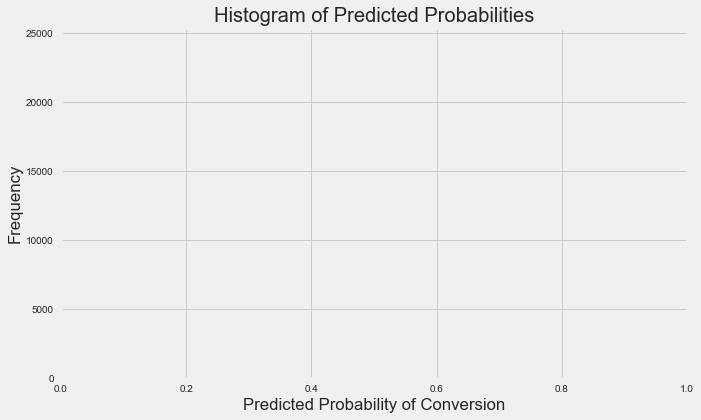

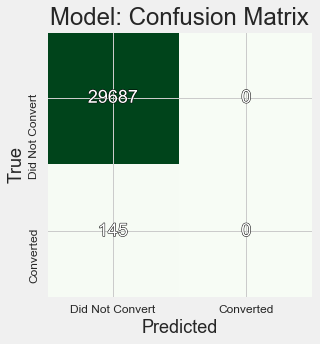

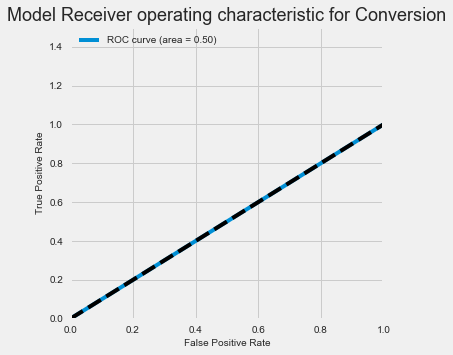

In [292]:
model_building(c_model, x_c,y_c , 'Logistic Regression')

In [293]:
# run feature selection classifier on churn model
feat_c = f_classif(x_c, y_c)
fit_c = LogisticRegression()
fit_c.fit(x_c,y_c)

# create DF to store coefficients and p-values
r2 = pd.DataFrame(data=fit_c.coef_[0],index=x_c.columns.values,columns=['coefficient'])
r2['pval'] = feat_c[1]
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,pval,sig
is_desktop,-1.396974,1.493038e-51,True
is_female,0.110661,1.406004e-01,False
Monday,-0.112365,4.541933e-01,False
Tuesday,-0.368221,1.700286e-01,False
Wednesday,-0.249368,8.715579e-01,False
Thursday,-0.419959,1.865422e-01,False
Friday,-0.192748,4.174721e-01,False
Saturday,-0.247173,7.251265e-01,False
1,-0.196588,1.256012e-16,True
2,-0.289824,6.380461e-11,True


Now let's take a look at our logistic regression model, which predicts the probability of converting.

We see 2 significant variables - is_desktop and months.
All have a negative coefficient, meaning the likelihood of converting decreases if you are using a desktop.  It also decreases greater if ou are a user in April vs January.

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5]), <a list of 13 Text xticklabel objects>)

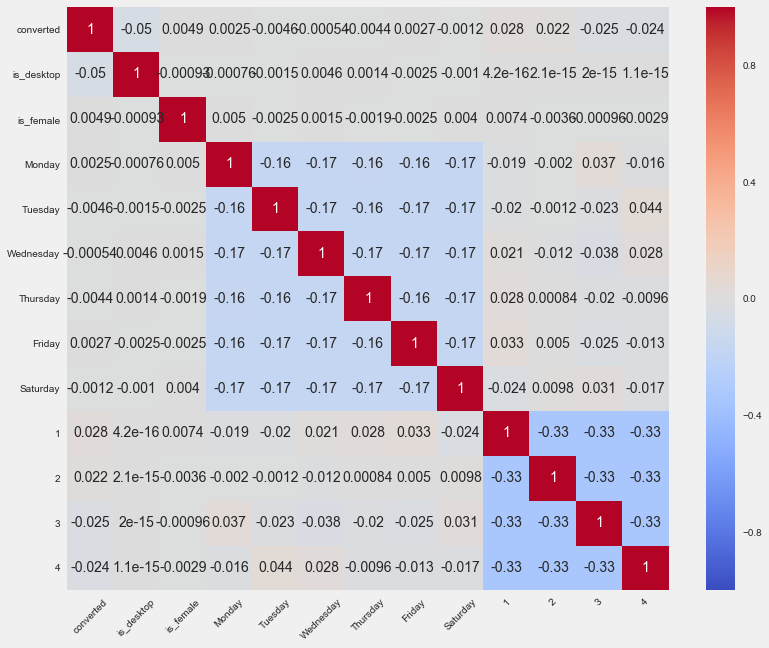

In [294]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True,cbar=True,cmap="coolwarm")
plt.xticks(rotation=45)

In [295]:
# run feature selection classifier on churn model
feat_c = f_classif(x_c, y_c)
fit_c = LogisticRegression()
fit_c.fit(x_c,y_c)

# create DF to store coefficients and p-values
r2 = pd.DataFrame(data=fit_c.coef_[0],index=x_c.columns.values,columns=['coefficient'])
r2['pval'] = feat_c[1]
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,pval,sig
is_desktop,-1.396974,1.493038e-51,True
is_female,0.110661,1.406004e-01,False
Monday,-0.112365,4.541933e-01,False
Tuesday,-0.368221,1.700286e-01,False
Wednesday,-0.249368,8.715579e-01,False
Thursday,-0.419959,1.865422e-01,False
Friday,-0.192748,4.174721e-01,False
Saturday,-0.247173,7.251265e-01,False
1,-0.196588,1.256012e-16,True
2,-0.289824,6.380461e-11,True


Building model Random Forest


/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:62: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Features importance:               values
index               
is_desktop  0.375928
is_female   0.121510
4           0.073574
Friday      0.065362
1           0.061667
2           0.058693
3           0.048267
Thursday    0.046360
Monday      0.040860
Saturday    0.038690
Wednesday   0.035341
Tuesday     0.033747
Accuracy for Random Forest = 99.52
[[29688     0]
 [  144     0]]


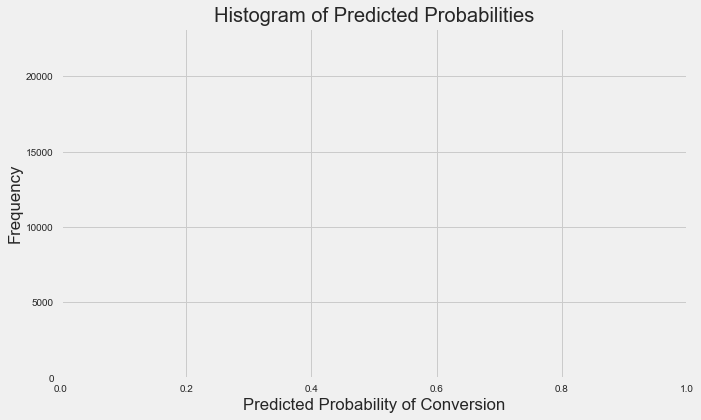

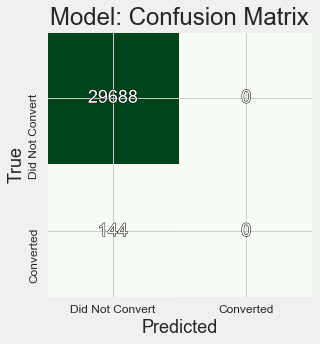

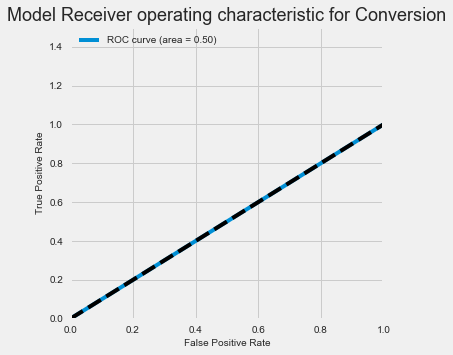

In [296]:
model_building(c_model, x_c,y_c , 'Random Forest')

TO DO

Add Conclusion

# Conclusion

Desktop users fare worse when converting than mobile, so the product team of this company should focus on improving the desktop experience.  Desktop users still make up the lion's share of the device split, so it would be prudent to improve the desktop flow and site.

The mobile site should not be forgotten though, as the success should be leveraged and improved even further.

Another point of note is that users convert better on Friday and Sunday.  So you could do something there like offer deals during the week, or another plan to bump of user engagement during the week.

